In [1]:
# coding=utf-8
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import *

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

## 1.dlib提取2D图片4个特征点

In [3]:
# 获取最大的人脸(get_landmark4函数内调用)
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [4]:
# 提取68个特征点(get_landmark4函数内调用)
def get_landmarks68(img):
    '''
    用dlib提取68个特征点
    :param img: 输入图像
    :return: 68个点的坐标，shape=(68，2)
    '''
    rects = detector(img, 1)
    if len(rects) == 0:
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

In [5]:
# 注释68个标记点(测试用)
def annotate_landmarks68(im):
    '''
    注释68个标记点
    :param im: 输入图片
    :return: 带有68个标记点的图片
    '''
    img = im.copy()
    landmarks68 = get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        # cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

In [6]:
# 选取dlib检测的68点中的4个特征点
def get_landmark4(img):
    '''
    用dlib获取人脸4个特征点
    :param img: 输入图片
    :return: 人脸4特征点的矩阵shape=(4,2)，若未检测到人脸，返回None
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark4 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(8).x, landmark68.part(8).y)  # 下巴
    ], dtype="double")
    return landmark4

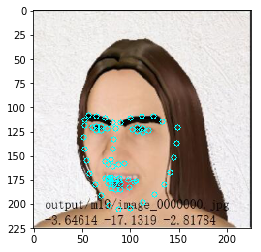

In [7]:
#-------------test--------------------------------------------------
#读取图像
img0 = cv2.imread('19.jpg')
img0=cv2.resize(img0,(225,225))
img = img0[:,:,::-1] # 调节色彩通道
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

[[  60.  120.]
 [ 120.  124.]
 [  79.  153.]
 [  87.  204.]]


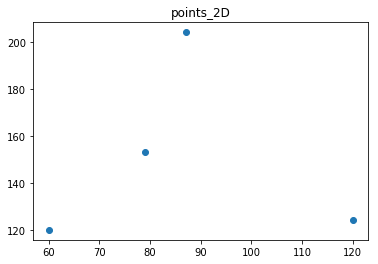

In [8]:
#-------------------------test--------------------------------------
points_2D=get_landmark4(img)
print(points_2D)
plt.scatter(points_2D.T[0],points_2D.T[1])
plt.title('points_2D')
plt.show()

## 2.手动构建4点人脸3D模型

In [9]:
# 手动构建4点人脸3D模型
def model_3D0():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (0.0, 330.0, -135.0)  #下巴
    ])
    return points_3D

In [10]:
# 手动构建4点人脸3D模型
def model_3D1():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, 0.0),  # 左眼左眼角
        (225.0, -170.0, 0.0),  # 右眼右眼角
        (0.0, 0.0, 105.0),  # 鼻尖
        (0.0, 170.0, 50.0)  #下巴
    ])
    return points_3D

In [11]:
# 手动构建4点人脸3D模型
def model_3D2():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (0.0, 330.0, -60.0)  #下巴(0.0, 330.0, 50.0)
    ])
    return points_3D

In [12]:
# 手动构建4点人脸3D模型
def model_3D():#学长paper
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D = np.array([
        (-226.0, -171.0, -136.0),  # 左眼左眼角
        (226.0, -171.0, -136.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (0.0, 331.0, -66.0)  #下巴(0.0, 330.0, 50.0)
    ])
    return points_3D

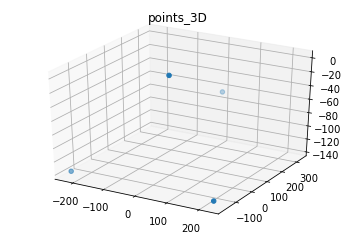

In [13]:
#---------------------------test------------------------------------
points_3D=model_3D()
#print(points_3D)
ax = plt.subplot(111, projection='3d')
ax.scatter(points_3D.T[0],points_3D.T[1],points_3D.T[2])
plt.title('points_3D')
plt.show()

## 3.归一化

In [14]:
# 归一化点
def get_normalize(points):
    '''
    归一化点
    :param 手动构建的3D模型(points_3D) 或 dlib检测到的4个特征点(points_2D)
    :return: 归一化后的点矩阵
    '''
    center = np.sum(points, axis=0) / points.shape[0]  # 中心
    L = np.sum(np.sum((points - center) ** 2, axis=1) ** 0.5)  # 归一化系数
    normalize = (points - center) / L
    return normalize, center, L

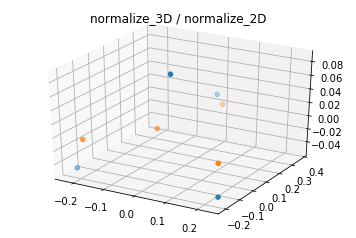

In [15]:
#------------------------------test---------------------------------
normalize_3D,center_3D, L_3D=get_normalize(points_3D)
normalize_2D,center_2D, L_2D=get_normalize(points_2D)
#print('normalize_3D=\n',normalize_3D)
#print('normalize_2D=\n',normalize_2D)
bx = plt.subplot(111, projection='3d')
bx.scatter(normalize_3D.T[0],normalize_3D.T[1],normalize_3D.T[2])
bx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D / normalize_2D')
plt.show()

## 4.求投影矩阵P

In [16]:
# 求投影矩阵P
def get_P_matrix(normalize_3D, normalize_2D):
    num = normalize_2D.shape[0]
    _ = 0  # _是要舍弃的值
    if num < 3:
        return -1
    elif num == 3:
        _, r1_T = cv2.solve(normalize_3D.T, normalize_2D.T[0], _)
        _, r2_T = cv2.solve(normalize_3D.T,normalize_2D.T[1], _)
    else:
        _, r1_T = cv2.solve(normalize_3D, normalize_2D.T[0], _, cv2.DECOMP_SVD)  # 奇异值分解
        _, r2_T = cv2.solve(normalize_3D, normalize_2D.T[1], _, cv2.DECOMP_SVD)
    r1 = r1_T.T[0]
    r2 = r2_T.T[0]
    r3 = np.cross(r1, r2)
    P = np.array([r1, r2])
    return P

In [17]:
#------------------------------test---------------------------------
P=get_P_matrix(normalize_3D,normalize_2D)
print('P=\n',P)

P=
 [[ 0.91086506  0.04411903 -0.61047578]
 [ 0.06072434  1.09468825  0.1876887 ]]


## 5.优化K

In [18]:
# 定义送入优化器的修正的目标函数
def f(K):
    '''
    修正的目标函数
    :param K: 待优化的参数
    :return: 修正的目标函数的值
    '''
    a=10**-6#9.399*10**-9
    disparity = (normalize_2D - np.dot(normalize_3D, P.T)).T  # disparity:d=b-P*a
    objective = np.sum(disparity ** 2)  # 目标函数
    # 惩罚函数
    penalty = np.sum((np.ones(4)-K[0:4])**2*normalize_3D.T[0]**2)+\
                np.sum((np.ones(4)-K[4:8])**2*normalize_3D.T[1]**2)+\
                np.sum((np.ones(4)-K[8:12])**2*normalize_3D.T[2]**2)
    revised_objective = objective + a * penalty  # 修正的目标函数
    return revised_objective

In [19]:
#------------------------------test---------------------------------
#K=np.random.random(normalize_3D.shape[0])
K=np.zeros((4,3))#初始化
K_opt=scipy.optimize.fmin_cg(f, K,gtol=1e-10)#共轭梯度下降法
#K_opt=scipy.optimize.leastsq(f, K,gtol=1e-5)#Levenberg–Marquardt算法
print('K_opt=\n',K_opt)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 6356
         Gradient evaluations: 454
K_opt=
 [ 1.00020448  1.00020448  0.          0.          0.99985386  0.99985386
  0.0361109   0.9999941   1.00522615  1.00522615  1.00450489  0.88991353]


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 6356
         Gradient evaluations: 454

K_opt= [ 1.00020448  1.00020448  0.          0.          0.99985386  0.99985386
  0.0361109   0.9999941   1.00522615  1.00522615  1.00450489  0.88991353]

label= [-3.64614, -17.1319, -2.81734]

theta= [ 11 -33  -3]
loss= 30.6969
theta_opt= [ 12 -33  -3]
loss= 31.6969


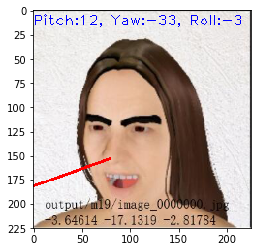

In [43]:
#-----------------test-main---------------------------------------------
label=[-3.64614,-17.1319,-2.81734]
label_02=[-10.3737,-7.72744,2.86461]
label_20=[-11.1298,14.6895,-3.71618]
img_with_line, theta=HeadPose_TIP_KXYZ(img)
plt.imshow(img_with_line)
plt.show()

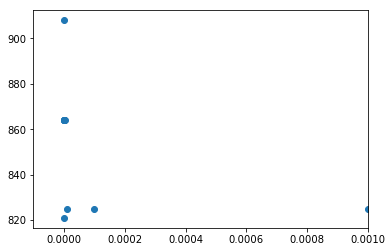

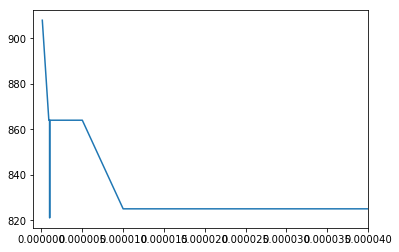

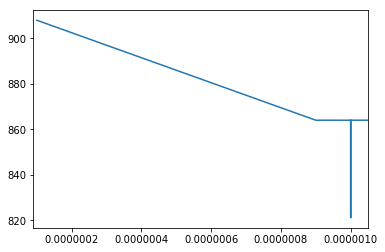

In [21]:
x=[10**-7 , 0.9*10**-6 , 0.9999999999999999*10**-6 , 10**-6 , 1.0000000001*10**-6 , 1.05*10**-6 , 1.1*10**-6 , 5*10**-6 , 10**-5 ,1*10**-4 , 1*10**-3 ]
y=[908,864,864,821,864,864,864,864,825,825,825]

plt.scatter(x,y)
plt.xlim(-10**-4,10**-3)
plt.show()

plt.plot(x,y)
plt.xlim(-10**-6,4*10**-5)
plt.show()

plt.plot(x,y)
plt.xlim(0.9*10**-7,1.05*10**-6)
plt.show()

In [22]:
#得到K修正后的3D模型(A_K)
def get_normalize_3D_K(normalize_3D, K_opt):
    '''
    计算经K修正的3D模型
    :param normalize_3D: 归一化的3D模型
    :param K_opt: 最优化K
    :return: K修正的3D模型
    '''
    normalize_3D_K = np.array([normalize_3D.T[0]*K_opt[0:4], normalize_3D.T[1]*K_opt[4:8], normalize_3D.T[2] * K_opt[8:12]])
    return normalize_3D_K.T

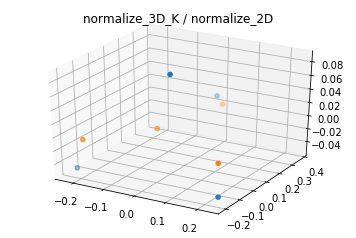

In [23]:
#------------------------------test---------------------------------
normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)
cx = plt.subplot(111, projection='3d')
cx.scatter(normalize_3D_K.T[0],normalize_3D_K.T[1],normalize_3D_K.T[2])
cx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D_K / normalize_2D')
plt.show()

## 6.计算K修正后的最优投影矩阵

In [24]:
# 得到K修正后的最优投影矩阵
def get_P_K_opt(normalize_2D, normalize_3D_K):
    '''
    计算K修正后的最优投影矩阵
    :param normalize_2D: 归一化2D特征点
    :param normalize_3D_K: 归一化K修正3D模型
    :return:最优投影矩阵
    '''
    P_K_opt = np.dot(np.dot(normalize_2D.T, normalize_3D_K), np.linalg.pinv(np.dot(normalize_3D_K.T, normalize_3D_K)))
    return P_K_opt

In [25]:
P_K_opt=get_P_K_opt(normalize_2D, normalize_3D_K)
P_K_opt

array([[ 0.91067884,  0.04092194, -0.60271716],
       [ 0.06071192,  1.09220683,  0.21113814]])

## 7.根据最优投影矩阵计算欧拉角

In [26]:
# 由最优投影矩阵计算欧拉角
def get_euler_angle(P_K_opt):
    '''
    由最优投影矩阵计算欧拉角
    :param P_opt: 最优投影矩阵
    :return: 欧拉角
    '''
    theta = np.array([0, 0, 0])  # (theta x,y,z)
    r1 = P_K_opt[0]
    r2 = P_K_opt[1]
    r3 = np.cross(r1, r2)
    #print('r3=', r3)
    theta[0] = -math.atan(r3[1] / r3[2]) / math.pi * 180#论文和data的参考系不一致，前面加负号和data一致
    theta[1] = -math.atan(r3[0] / (r3[1] ** 2 + r3[2] ** 2) ** 0.5) / math.pi * 180
    theta[2] = -math.atan(r2[0] / r1[0]) / math.pi * 180 #论文和data的参考系不一致，前面加负号和data一致
    return theta

In [27]:
#------------------------------test---------------------------------
theta=get_euler_angle(P_K_opt)
print('theta=',theta)

theta= [ 12 -33  -3]


## 8.画表示姿势的线

In [28]:
# 画表示姿势的线
def draw_line(img, points_2D,P_K_opt):
    '''
    画表示姿势的线
    :param img: 输入图片
    :param points_2D: dlib提取的2D特征点
    :return: 画有姿势线的图片
    '''
    nose_tip_2D = (int(points_2D[2][0]), int(points_2D[2][1]))
    far_3D = np.array([0.0, 0.0, 1000.0])
    far_2D = np.dot(np.dot(P_K_opt, (far_3D - center_3D) / L_3D), L_2D) + center_2D
    p1 = (int(nose_tip_2D[0]), int(nose_tip_2D[1]))
    p2 = (int(far_2D[0]), int(far_2D[1]))
    #print('p1=', p1, 'p2=', p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (255, 0, 0), 2)
    return img_with_line

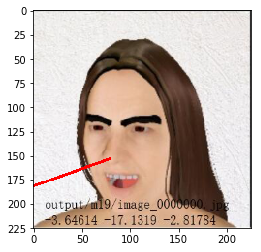

In [29]:
#-----------------test----------------------------------------------
img_with_line=draw_line(img,points_2D,P_K_opt)
plt.imshow(img_with_line)
plt.show()

# 头部姿势估计 main

In [30]:
def get_loss(theta,label):
    return np.sum(np.abs(label-theta))

In [41]:
# 主函数：头部姿势估计
def HeadPose_TIP_KXYZ(img):
    '''
    头部姿势估计
    :param img:输入图片 
    :return: 标有姿势线的图片，欧拉角
    '''
    points_2D = get_landmark4(img)  # dlib检测7个特征点
    points_3D = model_3D()  # 手动构建7点人脸3D模型

    normalize_3D, center_3D, L_3D = get_normalize(points_3D)  # 归一化
    normalize_2D, center_2D, L_2D = get_normalize(points_2D)

    P = get_P_matrix(normalize_3D, normalize_2D)  # 投影矩阵P
    theta=get_euler_angle(P)
    
    # K=np.random.random(normalize_3D.shape[0])
    K = np.zeros((4,3))  # 初始化
    K_opt = scipy.optimize.fmin_cg(f, K, gtol=1e-10)  # 共轭梯度下降法

    normalize_3D_K = get_normalize_3D_K(normalize_3D, K_opt)  # K修正后的3D模型

    P_K_opt = get_P_K_opt(normalize_2D, normalize_3D_K)  # K修正后的最优投影矩阵

    theta_opt = get_euler_angle(P_K_opt)  # 计算欧拉角

    img_with_line = draw_line(img, points_2D, P_K_opt)  # 画表示姿势的线
    
    theta_str = 'Pitch:{}, Yaw:{}, Roll:{}'.format(theta_opt[0],theta_opt[1],theta_opt[2])
    cv2.putText(img_with_line,theta_str, (0, 15), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)
    
    #print('normalize_2D=\n',normalize_2D)
    #print('\nnormalize_3D=\n',normalize_3D)
    #print("\nP=",P)
    print('\nK_opt=',K_opt)
    #print('\nnormalize_3D_K=\n',normalize_3D_K)
    #print('\nP_K_opt=\n',P_K_opt)
    print('\nlabel=',label)
    print('\ntheta=',theta)
    print('loss=',get_loss(theta,label))
    print('theta_opt=',theta_opt)
    print('loss=',get_loss(theta_opt,label))
    
    return img_with_line, theta_opt

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 6356
         Gradient evaluations: 454

K_opt= [ 1.00020448  1.00020448  0.          0.          0.99985386  0.99985386
  0.0361109   0.9999941   1.00522615  1.00522615  1.00450489  0.88991353]

label= [-3.64614, -17.1319, -2.81734]

theta= [ 11 -33  -3]
loss= 30.6969
theta_opt= [ 12 -33  -3]
loss= 31.6969


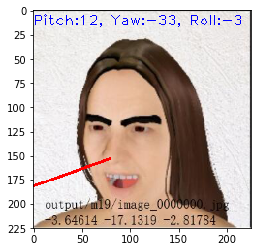

In [42]:
#-----------------test----------------------------------------------
label=[-3.64614,-17.1319,-2.81734]
label_02=[-10.3737,-7.72744,2.86461]
label_20=[-11.1298,14.6895,-3.71618]
img_with_line, theta=HeadPose_TIP_KXYZ(img)
plt.imshow(img_with_line)
plt.show()